##Import Excel with data

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ruta de tu archivo Excel
ruta_archivo_excel = 'ml-final-project-data.xlsx'

# Lee la primera página del archivo Excel
datos_pagina1 = pd.read_excel(ruta_archivo_excel, sheet_name='A')

# Lee la segunda página del archivo Excel
datos_pagina2 = pd.read_excel(ruta_archivo_excel, sheet_name='B')

# Junta los datos de las dos páginas en un solo DataFrame
df = pd.concat([datos_pagina1, datos_pagina2])


df_sin_y = df.drop('Y', axis=1)
Y = df['Y']

del df

##Verificar datos faltantes

In [40]:
# Verifica si hay datos faltantes en el DataFrame
valores_faltantes = df_sin_y.isnull().sum()

# Calcula la suma total de valores faltantes en el DataFrame
total_valores_faltantes = df_sin_y.isnull().sum().sum()

# Muestra la suma total de valores faltantes en el DataFrame
print("Suma total de valores faltantes en el DataFrame:", total_valores_faltantes)

Suma total de valores faltantes en el DataFrame: 0


##Imputación de datos atípicos

In [41]:
# Calcula el rango intercuartílico para cada columna
Q1 = df_sin_y.quantile(0.25)
Q3 = df_sin_y.quantile(0.75)
IQR = Q3 - Q1

# Identifica los valores atípicos en cada columna
outliers = (df_sin_y < (Q1 - 1.5 * IQR)) | (df_sin_y > (Q3 + 1.5 * IQR))

# Reemplazar los valores atípicos por la mediana de cada columna
for col in df_sin_y.columns:
    median = df_sin_y[col].median()

    # Calcular el límite máximo permitido de valores atípicos (5%)
    limite_atipicos = len(df_sin_y) * 0.05

    # Verificar si el número de valores atípicos supera el límite
    if outliers[col].sum() > limite_atipicos:
        df_sin_y[col] = df_sin_y[col].where(~outliers[col], median)

##Normalización

In [42]:
from sklearn.preprocessing import MinMaxScaler

# Instancia el MinMaxScaler
scaler = MinMaxScaler()

# Normaliza los datos
datos_normalizados = scaler.fit_transform(df_sin_y)

# Crea un nuevo DataFrame con los datos normalizados
datos_normalizados = pd.DataFrame(datos_normalizados, columns=df_sin_y.columns)

del df_sin_y

##PCA

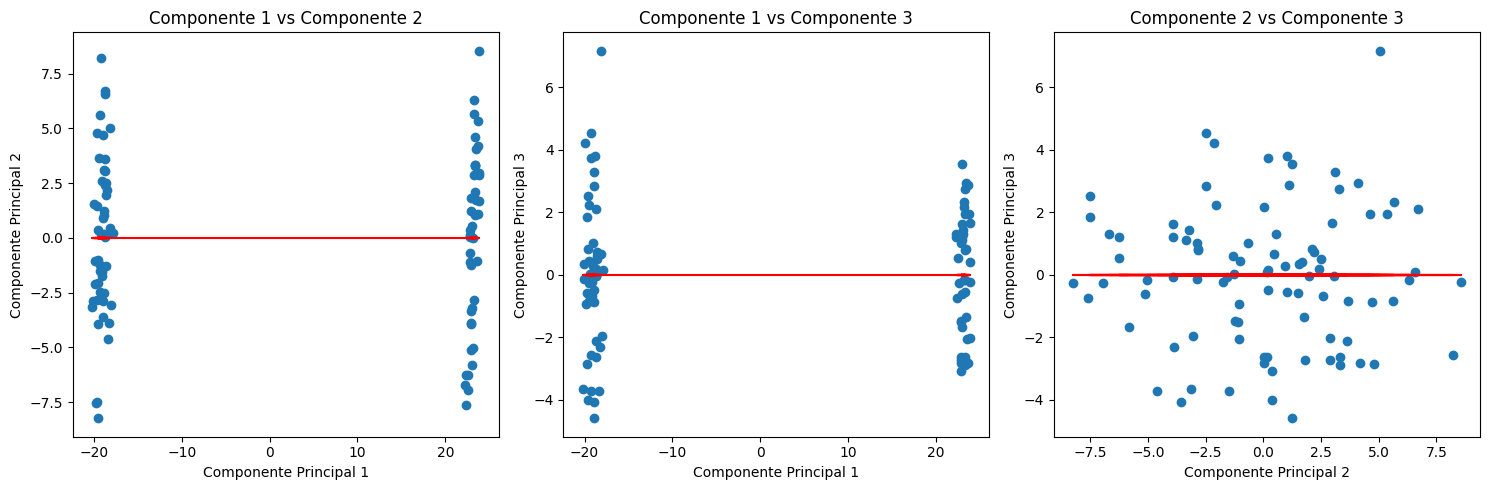

[0.92088522 0.030202   0.01005328]
[0.92088522 0.95108722 0.9611405 ]


In [43]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Escala los datos
scaler = StandardScaler()
datos_escalados = scaler.fit_transform(datos_normalizados)

# Aplica PCA con tres componentes principales
pca = PCA(n_components=3)
componentes_principales = pca.fit_transform(datos_escalados)

# Crea un DataFrame con los tres componentes principales para facilitar la visualización
df_componentes = pd.DataFrame(data=componentes_principales, columns=['Componente 1', 'Componente 2', 'Componente 3'])

# Configuración de los gráficos en una fila
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Función para ajustar y graficar la línea de regresión
def graficar_linea_regresion(x, y, ax):
    coeficientes = np.polyfit(x, y, 1)
    polinomio = np.poly1d(coeficientes)
    ax.plot(x, polinomio(x), color='red')

# Graficar Componente 1 vs Componente 2
axs[0].scatter(df_componentes['Componente 1'], df_componentes['Componente 2'])
graficar_linea_regresion(df_componentes['Componente 1'], df_componentes['Componente 2'], axs[0])
axs[0].set_xlabel('Componente Principal 1')
axs[0].set_ylabel('Componente Principal 2')
axs[0].set_title('Componente 1 vs Componente 2')

# Graficar Componente 1 vs Componente 3
axs[1].scatter(df_componentes['Componente 1'], df_componentes['Componente 3'])
graficar_linea_regresion(df_componentes['Componente 1'], df_componentes['Componente 3'], axs[1])
axs[1].set_xlabel('Componente Principal 1')
axs[1].set_ylabel('Componente Principal 3')
axs[1].set_title('Componente 1 vs Componente 3')

# Graficar Componente 2 vs Componente 3
axs[2].scatter(df_componentes['Componente 2'], df_componentes['Componente 3'])
graficar_linea_regresion(df_componentes['Componente 2'], df_componentes['Componente 3'], axs[2])
axs[2].set_xlabel('Componente Principal 2')
axs[2].set_ylabel('Componente Principal 3')
axs[2].set_title('Componente 2 vs Componente 3')

# Ajustar y mostrar los gráficos
plt.tight_layout()
plt.show()

print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())



##Regresión Polinomial

In [44]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
import copy

# Suponiendo que tienes tus datos en RP_X_train y RP_Y_train
RP_Y_train = Y  # Reemplaza 'Variable_Objetivo' con el nombre de tu columna objetivo
RP_X_train = datos_normalizados # Elimina la columna objetivo para obtener las características

# Aplicar regresión polinomial
poly = PolynomialFeatures(degree=2)  # Establece el grado del polinomio según sea necesario
RP_X_train_poly = poly.fit_transform(RP_X_train)

# Aplicar PCA a las características polinomiales
RP_X_train_pca = pca.fit_transform(RP_X_train_poly)

# Entrenar un modelo de regresión lineal con los datos transformados y realizar predicciones mediante validación cruzada
regressor = LinearRegression()

# Realizar predicciones mediante validación cruzada
RP_y_pred = cross_val_predict(regressor, RP_X_train_pca, RP_Y_train, cv=10)

# Calcular el Error Cuadrático Medio (MSE)
mse = mean_squared_error(RP_Y_train, RP_y_pred)
print(f"Error cuadrático medio en validación cruzada: {mse}")

# Calcular el coeficiente de determinación (R^2)
r2 = r2_score(RP_Y_train, RP_y_pred)
print(f"Coeficiente de determinación (R^2) en validación cruzada: {r2}")



Error cuadrático medio en validación cruzada: 3.2532309334542657
Coeficiente de determinación (R^2) en validación cruzada: 0.029726076447431082


##Red neuronal

In [45]:
'''import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

# Suponiendo que 'X_train', 'Y_train' son tus datos de entrenamiento originales
# Suponiendo también que 'pca' es tu modelo PCA ya ajustado
# Separar la variable objetivo (Y_train) del resto de características (X_train)
Y_train = Y  # Reemplaza 'Variable_Objetivo' con el nombre de tu columna objetivo
X_train = datos_normalizados # Elimina la columna objetivo para obtener las características

# Transformar los datos de entrenamiento usando PCA
x_pca_train = pca.transform(X_train)

# Definir el modelo de red neuronal
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(x_pca_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu', input_shape=(x_pca_train.shape[1],)),
    tf.keras.layers.Dense(1)  # Capa de salida con una neurona para regresión
])

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Inicializar listas para almacenar resultados de métricas
all_mse = []
all_r2 = []

# Configurar la validación cruzada de 10-fold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Realizar validación cruzada
for train_index, test_index in kf.split(x_pca_train):
    x_train_fold, x_val_fold = x_pca_train[train_index], x_pca_train[test_index]
    y_train_fold, y_val_fold = Y_train.iloc[train_index], Y_train.iloc[test_index]

    # Early Stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',  # Métrica a monitorizar
        patience=30,          # Cantidad de épocas para esperar antes de detener el entrenamiento si no hay mejoras
        restore_best_weights=True  # Restaurar los pesos del modelo a la mejor época
    )

    # Entrenar el modelo con Early Stopping
    model.fit(x_train_fold, y_train_fold, epochs=200, batch_size=10, validation_data=(x_val_fold, y_val_fold), callbacks=[early_stopping], verbose=0)

    # Evaluar el modelo en el conjunto de prueba (en este caso, el conjunto de validación fold)
    mse = model.evaluate(x_val_fold, y_val_fold)
    all_mse.append(mse)

    # Realizar predicciones en el conjunto de validación fold
    predictions = model.predict(x_val_fold)

    # Calcular R^2 en el conjunto de validación fold
    r2 = r2_score(y_val_fold, predictions)
    all_r2.append(r2)

# Calcular el promedio de las métricas obtenidas en cada fold
avg_mse = np.mean(all_mse)
avg_r2 = np.mean(all_r2)

# Imprimir resultados promedio
print(f"Error cuadrático medio promedio en validación cruzada: {avg_mse}")
print(f"Coeficiente de determinación R^2 promedio en validación cruzada: {avg_r2}")'''


'import numpy as np\nimport tensorflow as tf\nfrom sklearn.preprocessing import StandardScaler\nfrom sklearn.model_selection import KFold\nfrom sklearn.metrics import mean_squared_error, r2_score\n\n# Suponiendo que \'X_train\', \'Y_train\' son tus datos de entrenamiento originales\n# Suponiendo también que \'pca\' es tu modelo PCA ya ajustado\n# Separar la variable objetivo (Y_train) del resto de características (X_train)\nY_train = Y  # Reemplaza \'Variable_Objetivo\' con el nombre de tu columna objetivo\nX_train = datos_normalizados # Elimina la columna objetivo para obtener las características\n\n# Transformar los datos de entrenamiento usando PCA\nx_pca_train = pca.transform(X_train)\n\n# Definir el modelo de red neuronal\nmodel = tf.keras.Sequential([\n    tf.keras.layers.Dense(128, activation=\'relu\', input_shape=(x_pca_train.shape[1],)),\n    tf.keras.layers.Dense(64, activation=\'relu\', input_shape=(x_pca_train.shape[1],)),\n    tf.keras.layers.Dense(1)  # Capa de salida con

## SVR

In [46]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
import numpy as np

# Suponiendo que tienes tus datos en X_train y Y_train
Y_train = Y  # Reemplaza 'Variable_Objetivo' con el nombre de tu columna objetivo
X_train = datos_normalizados # Elimina la columna objetivo para obtener las características

# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Definir el modelo SVR con kernel RBF
model = SVR(kernel='rbf')

# Definir KFold (10 folds)
kf = KFold(n_splits=10)

# Entrenamiento y evaluación con validación cruzada
mse_scores = []
r2_scores = []

for train_index, test_index in kf.split(X_train_scaled):
    X_train_kfold, X_test_kfold = X_train_scaled[train_index], X_train_scaled[test_index]
    Y_train_kfold, Y_test_kfold = Y_train.iloc[train_index], Y_train.iloc[test_index]

    # Entrenar el modelo SVR
    model.fit(X_train_kfold, Y_train_kfold)

    # Realizar predicciones
    predicciones = model.predict(X_test_kfold)

    # Calcular métricas
    mse = mean_squared_error(Y_test_kfold, predicciones)
    r2 = r2_score(Y_test_kfold, predicciones)

    mse_scores.append(mse)
    r2_scores.append(r2)

# Calcular el promedio de las métricas obtenidas en cada fold
avg_mse = np.mean(mse_scores)
avg_r2 = np.mean(r2_scores)

# Imprimir resultados promedio
print(f"Error cuadrático medio promedio en validación cruzada: {avg_mse}")
print(f"Coeficiente de determinación R^2 promedio en validación cruzada: {avg_r2}")


Error cuadrático medio promedio en validación cruzada: 3.288975741239347
Coeficiente de determinación R^2 promedio en validación cruzada: -13.321980824178524


##Gradient Boosting

In [47]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Suponiendo que tienes tus datos en X_train y Y_train
Y_train = Y  # Reemplaza 'Variable_Objetivo' con el nombre de tu columna objetivo
X_train = datos_normalizados # Elimina la columna objetivo para obtener las características

# Inicializar y aplicar PCA
X_train_pca = pca.fit_transform(X_train)

# Inicializar el modelo Gradient Boosting Regressor
gradient_boosting = GradientBoostingRegressor()

# Realizar predicciones mediante validación cruzada
GB_y_pred = cross_val_predict(gradient_boosting, X_train_pca, Y_train, cv=10)

# Calcular el Error Cuadrático Medio (MSE)
mse = mean_squared_error(Y_train, GB_y_pred)
print(f"Error cuadrático medio en validación cruzada: {mse}")

# Calcular el coeficiente de determinación (R^2)
r2 = r2_score(Y_train, GB_y_pred)
print(f"Coeficiente de determinación (R^2) en validación cruzada: {r2}")


Error cuadrático medio en validación cruzada: 4.275247165903779
Coeficiente de determinación (R^2) en validación cruzada: -0.2750895730030336
